Importing Required Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Density Calculation Functions

In [2]:
def calculate_density(patch):
    return np.sum(patch) / (patch.size * 255)

Horiontal and Vertical Transitions

In [3]:
def calculate_transitions(patch):
    horizontal_transitions = np.sum(np.abs(np.diff(patch, axis=1))) / 255
    vertical_transitions = np.sum(np.abs(np.diff(patch, axis=0))) / 255
    return horizontal_transitions, vertical_transitions

Height and Weight Variations

In [4]:
def compute_variation(contours):
    heights = [cv2.boundingRect(contour)[3] for contour in contours]
    widths = [cv2.boundingRect(contour)[2] for contour in contours]
    return np.std(heights), np.std(widths) if heights and widths else (0, 0)

Component Generation

In [5]:
def compute_components(patch):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(patch)
    sizes = stats[1:, cv2.CC_STAT_AREA]
    return num_labels - 1, np.max(sizes) if sizes.size > 0 else 0

Computing Run Lengths

In [6]:
def compute_run_lengths(patch):
    max_run_length = 0
    total_run_length = 0
    run_count = 0
    for row in patch:
        current_run_length = 0
        for pixel in row:
            if pixel == 255:
                current_run_length += 1
            else:
                if current_run_length > 0:
                    max_run_length = max(max_run_length, current_run_length)
                    total_run_length += current_run_length
                    run_count += 1
                    current_run_length = 0
        if current_run_length > 0:
            max_run_length = max(max_run_length, current_run_length)
            total_run_length += current_run_length
            run_count += 1
    avg_run_length = total_run_length / run_count if run_count > 0 else 0
    return max_run_length, avg_run_length

Convex Hull Computation

In [7]:
def compute_convex_hull(patch):
    contours, _ = cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        all_points = np.vstack(contours)
        hull = cv2.convexHull(all_points)
        return len(hull)
    else:
        return 0

Gabor Filter

In [9]:
def apply_gabor_filter(patch, kernel_size=31, sigma=4.0, lambd=10.0, gamma=0.5, psi=0, theta=0):
    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    filtered_patch = cv2.filter2D(patch, cv2.CV_8UC3, kernel)
    return filtered_patch

def extract_gabor_features(patch):
    gabor_features = {}
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Four orientations: 0, 45, 90, 135 degrees
    for i, theta in enumerate(thetas):
        filtered_patch = apply_gabor_filter(patch, theta=theta)
        gabor_features[f'gabor_mean_{i}'] = np.mean(filtered_patch)
        gabor_features[f'gabor_std_{i}'] = np.std(filtered_patch)
    return gabor_features

Cumulative Function for extracting State Features

In [10]:
def extract_state_features(patches):
    state_features_list = []
    for stat, patch in patches:
        features = {}
        # State features
        features['height'] = stat[cv2.CC_STAT_HEIGHT]
        features['width'] = stat[cv2.CC_STAT_WIDTH]
        features['aspect_ratio'] = features['width'] / features['height']
        features['density'] = calculate_density(patch)
        horizontal_transitions, vertical_transitions = calculate_transitions(patch)
        features['horizontal_transitions'] = horizontal_transitions
        features['vertical_transitions'] = vertical_transitions
        variation_of_height, width_variation = compute_variation(patch)
        features['variation_of_height'] = variation_of_height
        features['width_variation'] = width_variation
        num_components, max_component_size = compute_components(patch)
        features['num_components'] = num_components
        features['max_component_size'] = max_component_size
        max_run_length, avg_run_length = compute_run_lengths(patch)
        features['max_run_length'] = max_run_length
        features['avg_run_length'] = avg_run_length
        features['points_in_convex_hull'] = compute_convex_hull(patch)
        gabor_features = extract_gabor_features(patch)
        features.update(gabor_features)        
        # Append to the state features list
        state_features_list.append(features)
    return state_features_list

Distance Between two Convex Hulls

In [11]:
def calculate_distance_between_hulls(hull1, hull2):
    min_dist = float('inf')
    for point1 in hull1:
        for point2 in hull2:
            dist = np.linalg.norm(point1 - point2)
            if dist < min_dist:
                min_dist = dist
    return min_dist

Relative Location calculation

In [12]:
def determine_relative_location(patch1_stat, patch2_stat):
    centroid1_x = patch1_stat[cv2.CC_STAT_LEFT] + patch1_stat[cv2.CC_STAT_WIDTH] / 2
    centroid2_x = patch2_stat[cv2.CC_STAT_LEFT] + patch2_stat[cv2.CC_STAT_WIDTH] / 2
    centroid1_y = patch1_stat[cv2.CC_STAT_TOP] + patch1_stat[cv2.CC_STAT_HEIGHT] / 2
    centroid2_y = patch2_stat[cv2.CC_STAT_TOP] + patch2_stat[cv2.CC_STAT_HEIGHT] / 2
    if centroid1_x < centroid2_x:
        return 'left'
    elif centroid1_x > centroid2_x:
        return 'right'
    elif centroid1_y < centroid2_y:
        return 'top'
    else:
        return 'bottom'

Cumulative Function for extracting Transition Features

In [13]:
def extract_transition_features(patches, state_features):
    transition_features_list = []
    for i in range(len(patches) - 1):
        patch1_stat, patch1 = patches[i]
        patch2_stat, patch2 = patches[i + 1]
        features = {}
        features['relative_location'] = determine_relative_location(patch1_stat, patch2_stat)
        features['convex_hull_distance'] = calculate_distance_between_hulls(patch1, patch2)
        features['ratio_of_aspect_ratios'] = (state_features[i]['aspect_ratio'] /
                                              state_features[i + 1]['aspect_ratio'])
        features['ratio_of_number_of_components'] = (state_features[i]['num_components'] /
                                                     state_features[i + 1]['num_components'])
        transition_features_list.append(features)
    return transition_features_list

Preprocessing Functions

In [14]:
def convert_to_binary(image_path, threshold=127):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY_INV)
    return binary

def find_patches(binary_image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    min_area = 10  # This is a parameter you might need to tune
    patches = [(stats[i], (labels == i).astype(np.uint8) * 255) for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > min_area]
    return patches

In [16]:
image_path = '/home/tanishpatel01/DIP_23CP311T_Project/Gujarati/1.jpg'
binary_image = convert_to_binary(image_path)

# Find patches
patches = find_patches(binary_image)

Patch Processing

In [17]:
def process_patches(patches):
    state_features = extract_state_features(patches)
    transition_features = extract_transition_features(patches, state_features)
    return state_features, transition_features

In [18]:
state_features, transition_features = process_patches(patches)

Displaying Processed Features

In [19]:
for i, features in enumerate(state_features):
    print(f'Patch {i} state features: {features}')
for i, features in enumerate(transition_features):
    print(f'Patch {i} transition features: {features}')


Patch 0 state features: {'height': 292, 'width': 420, 'aspect_ratio': 1.4383561643835616, 'density': 0.010367236696809622, 'horizontal_transitions': 21.223529411764705, 'vertical_transitions': 13.670588235294117, 'variation_of_height': 42.821050131876696, 'width_variation': 0.0, 'num_components': 1, 'max_component_size': 2779, 'max_run_length': 420, 'avg_run_length': 8.907051282051283, 'points_in_convex_hull': 4, 'gabor_mean_0': 7.398662965947414, 'gabor_std_0': 41.167481399267444, 'gabor_mean_1': 6.595905333213955, 'gabor_std_1': 39.29134399764008, 'gabor_mean_2': 7.099468021607425, 'gabor_std_2': 40.65305992101724, 'gabor_mean_3': 6.683748918136509, 'gabor_std_3': 39.55964509530945}
Patch 1 state features: {'height': 2, 'width': 13, 'aspect_ratio': 6.5, 'density': 5.222789267914167e-05, 'horizontal_transitions': 2.007843137254902, 'vertical_transitions': 0.050980392156862744, 'variation_of_height': 0.761507083416465, 'width_variation': 0.08247667519720751, 'num_components': 1, 'max_c

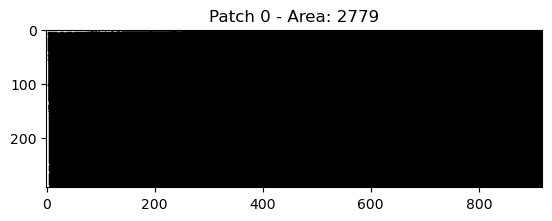

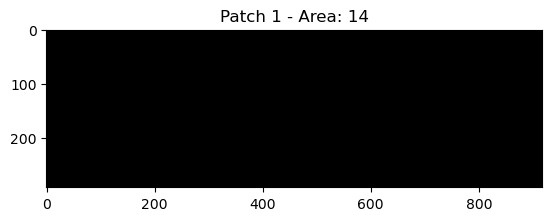

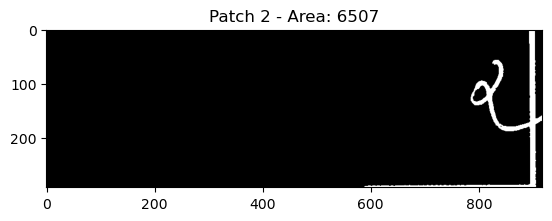

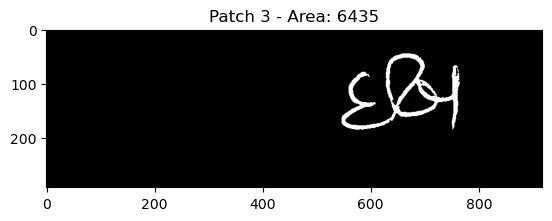

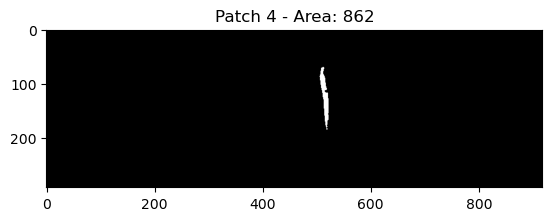

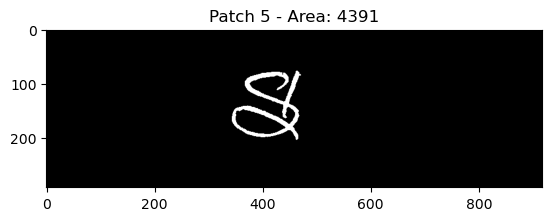

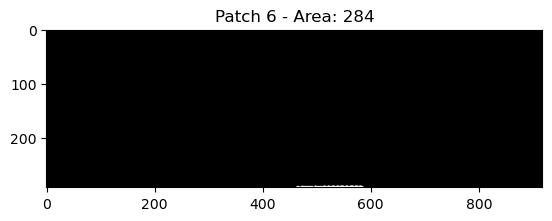

In [20]:
for i, (stat, patch) in enumerate(patches):
    plt.figure()
    plt.imshow(patch, cmap='gray')
    plt.title(f'Patch {i} - Area: {stat[cv2.CC_STAT_AREA]}')
    plt.show()

In [21]:
import pandas as pd

state_ft = pd.DataFrame(state_features)

In [22]:
state_ft.to_csv('state_features_1.csv', index_label="Patch ID", index=True)